<a href="https://colab.research.google.com/github/mattrosenblatt7/self_citation/blob/main/self_citation_colab_analyses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code runs the analyses presented in https://www.biorxiv.org/content/10.1101/2022.09.27.509533v2 (see also GitHub page: https://github.com/mattrosenblatt7/self_citation). Please note that several cells in this notebook are deleted that would require long runtimes and loading/saving many files. Instead, it loads pre-saved data directly from GitHub

Please also note that the code and data are for academic and non-commercial use only. The Creative Commons Attribution-NonCommercial 4.0 International Public License (license link: https://creativecommons.org/licenses/by-nc/4.0/legalcode) applies, as described on our GitHub page: https://github.com/mattrosenblatt7/self_citation/blob/main/LICENSE

In [1]:
%%capture
!pip install geopandas
!pip install country_converter
!pip install seaborn=0.11.2

In [21]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # ignore future warnings (pandas)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import linregress, spearmanr
import glob
import json
import country_converter as coco
from datetime import datetime, timedelta
import requests
import geopandas as gpd
from seaborn.utils import ci
import colorcet as cc
import os
import requests as rq
from io import BytesIO

sns.set_context('poster')
custom_palette = ['#1b9e77','#7570b3','#d95f02']

In [3]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'
base_path = './figures/'  # set for saving figures

In [4]:
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    return percentile_

# Load

In [16]:
# load data from github
url = "https://raw.githubusercontent.com/mattrosenblatt7/self_citation/main/raw_data_analysis/self_citation_data.xlsx"
data = rq.get(url).content
df = pd.read_excel(BytesIO(data))
num_topics = 13  # this particular .csv file was based on 13 topics


# print quantiles of self-citation rates
df.groupby(['SC Type'], as_index=False)['sc_rate'].agg([percentile(.01), percentile(.05),
                                            percentile(.1), percentile(.25),
                                            percentile(.5), percentile(.75),
                                            percentile(.90), percentile(.95),
                                            percentile(.99)])



,SC Type,percentile_01,percentile_05,percentile_10,percentile_25,percentile_50,percentile_75,percentile_90,percentile_95,percentile_99
0,Any,0.0,0.0,0.02381,0.066667,0.135135,0.227273,0.333333,0.411765,0.583333
1,FA,0.0,0.0,0.00000,0.000000,0.028571,0.076923,0.150000,0.208333,0.357143
2,LA,0.0,0.0,0.00000,0.024390,0.071429,0.137931,0.219512,0.282051,0.419355


# Load bootstrap results:
Note that these only include 500 permutations to improve loading speed and reduce storage size (the paper includes 1000)

In [27]:
def load_npz_from_link(url):
  '''
  Function that loads .npz files from a URL (in this case, our GitHub page)
  Credit to: https://stackoverflow.com/questions/48355140/load-npz-from-a-http-link
  '''
  r = requests.get(url, stream=True)
  return np.load(BytesIO(r.raw.read()), allow_pickle=True)

In [28]:
dat = load_npz_from_link('https://github.com/mattrosenblatt7/self_citation/blob/main/results/boot_results.npz?raw=true')

# Descriptive stats

In [29]:
fa_recent_sc = dat['fa_recent_sc']
la_recent_sc = dat['la_recent_sc']
any_recent_sc = dat['any_recent_sc']

# summarize data frame
fields = ['All', 'Neurology', 'Neuroscience', 'Psychiatry']

for i, field in enumerate(fields):

  print(field + ': First author: ' + '{:.6f}'.format(np.mean(fa_recent_sc[:, i])) + \
        ' (' + '{:.6f}'.format(np.percentile(fa_recent_sc[:, i], q=2.5)) + ', ' + '{:.6f}'.format(np.percentile(fa_recent_sc[:, i], q=97.5)) + ')' + \
        '; Last author: ' +  '{:.6f}'.format(np.mean(la_recent_sc[:, i])) + \
        ' (' + '{:.6f}'.format(np.percentile(la_recent_sc[:, i], q=2.5)) + ', ' + '{:.6f}'.format(np.percentile(la_recent_sc[:, i], q=97.5)) + ')' + \
        '; Any author: '  +  '{:.6f}'.format(np.mean(any_recent_sc[:, i])) + \
        ' (' + '{:.6f}'.format(np.percentile(any_recent_sc[:, i], q=2.5)) + ', ' + '{:.6f}'.format(np.percentile(any_recent_sc[:, i], q=97.5)) + ')' )

  # print('P value for first vs last difference: ' + '{:.5f}'.format(1-np.mean((la_recent_sc[:, 1] - fa_recent_sc[:, 1])>0)))

All: First author: 0.039838 (0.038746, 0.040712); Last author: 0.081585 (0.079760, 0.083033); Any author: 0.144065 (0.139913, 0.147364)
Neurology: First author: 0.045421 (0.043643, 0.046959); Last author: 0.088729 (0.085186, 0.091392); Any author: 0.165911 (0.158545, 0.171609)
Neuroscience: First author: 0.034123 (0.032970, 0.035130); Last author: 0.075437 (0.073592, 0.077323); Any author: 0.126118 (0.122927, 0.129090)
Psychiatry: First author: 0.042893 (0.041128, 0.044264); Last author: 0.084081 (0.081631, 0.086008); Any author: 0.150709 (0.144799, 0.154728)


# Figure 1 - 2020 and over years

## histogram

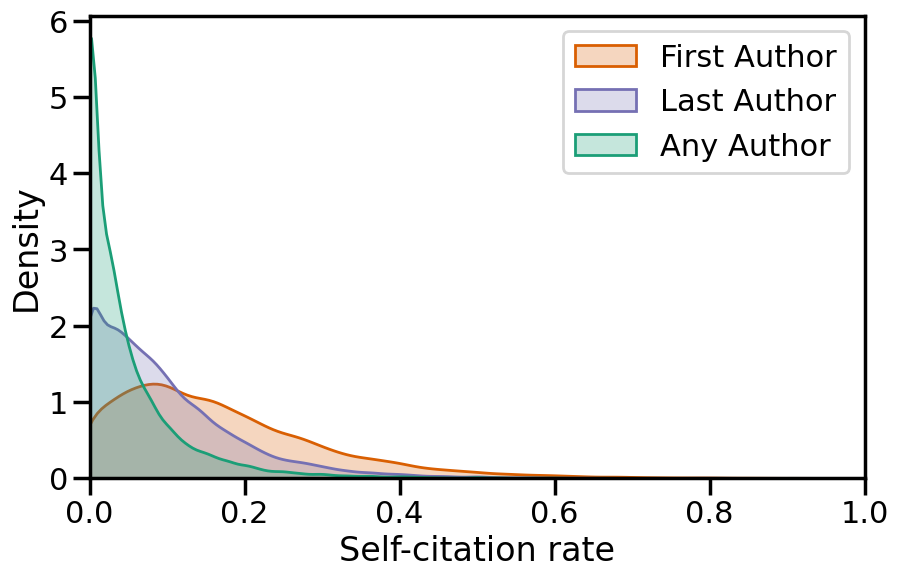

In [30]:
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(data=df[df.Year.isin([2016, 2017, 2018, 2019, 2020])], x='sc_rate', hue='SC Type', fill=True, ax=ax, palette=custom_palette[:3])
ax.set_xlim(0, 1)

ax.set_xlabel('Self-citation rate')
ax.legend(labels=['First Author', 'Last Author', 'Any Author'])

## over time

In [31]:
'''
print correlations and slopes for first author (first column),
last author (second column),
and any author (third column)
'''

# r values
print('****r values****')
print(np.mean(dat['r_boot'], axis=0))
print(np.percentile(dat['r_boot'], q=2.5, axis=0))
print(np.percentile(dat['r_boot'], q=97.5, axis=0))

# m values
print('****m values (%)****')
print(100*10*np.mean(dat['m_boot'], axis=0))  # 100*10 for percente per decade
print(100*10*np.percentile(dat['m_boot'], q=2.5, axis=0))
print(100*10*np.percentile(dat['m_boot'], q=97.5, axis=0))

****r values****
[-0.98223737 -0.39163848  0.5050628 ]
[-0.99033379 -0.62579688  0.10263349]
[-0.97167587 -0.12469216  0.72826513]
****m values (%)****
[-1.21063355 -0.17530962  0.32362104]
[-1.30226984 -0.3050877   0.05291984]
[-1.12451832 -0.05288527  0.54972144]


In [32]:
# print self-citation rates in 2000 and 2020

print('********Year 2000********')
print(np.mean(dat['sc_rates'][:, 0, :], axis=0))
print(np.percentile(dat['sc_rates'][:, 0, :], q=2.5, axis=0))
print(np.percentile(dat['sc_rates'][:, 0, :], q=97.5, axis=0))

print('********Year 2020********')
print(np.mean(dat['sc_rates'][:, -1, :], axis=0))
print(np.percentile(dat['sc_rates'][:, -1, :], q=2.5, axis=0))
print(np.percentile(dat['sc_rates'][:, -1, :], q=97.5, axis=0))


********Year 2000********
[0.06222882 0.08623243 0.14320296]
[0.05965761 0.08360369 0.13966431]
[0.06469632 0.08895517 0.14685719]
********Year 2020********
[0.03681783 0.07637263 0.13849057]
[0.03531083 0.07385059 0.13366968]
[0.03806466 0.07838933 0.14274027]


Text(0, 0.5, 'Self-citation rate')

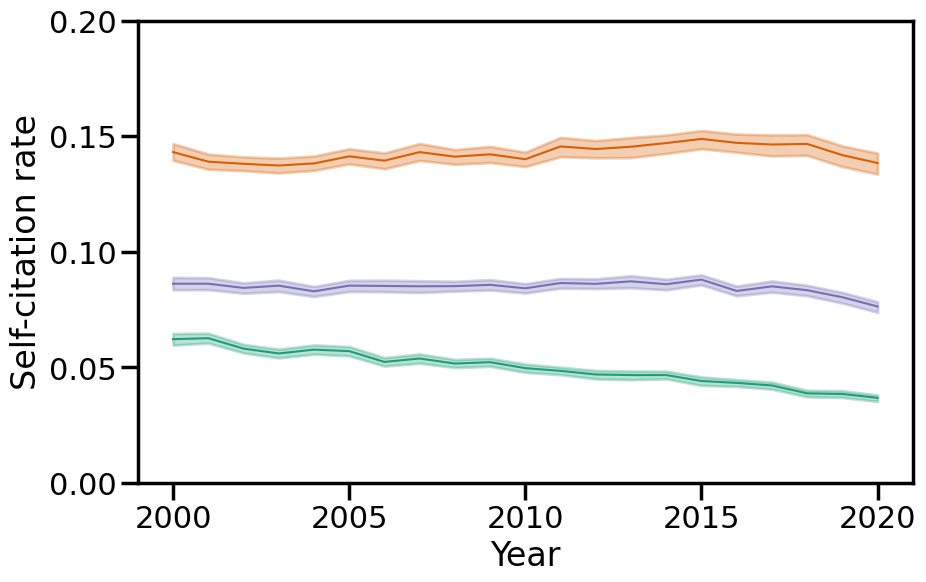

In [33]:
# Make plot of self-citation rate over time

sns.set_context('poster')
ordering = ['First Author', 'Last Author', 'Any Author']
years = np.arange(2000, 2021)
fig, ax = plt.subplots(figsize=(10, 6))
colors = custom_palette[:3]
sc_rates_time = dat['sc_rates']

for i, sc_type in enumerate(ordering):
    sc_time_iter = np.mean(sc_rates_time[:, :, i], axis=0)  # either first, last or any
    sc_lower = np.percentile(sc_rates_time[:, :, i], q=2.5, axis=0)
    sc_upper = np.percentile(sc_rates_time[:, :, i], q=97.5, axis=0)

    ax.plot(years, sc_time_iter, label=sc_type, color=custom_palette[i], linewidth=1.5)
    ax.fill_between(years, sc_lower, sc_upper, color=custom_palette[i], alpha=.3)

ax.set_xticks([2000, 2005, 2010, 2015, 2020])
ax.set_ylim([0, 0.2])
ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2])
ax.set_xlabel('Year')
ax.set_ylabel('Self-citation rate')

Convert r to p values

In [34]:
# Convert correlations between self-citation rate and year to p values

import scipy
r1, r2, r3 = np.median(dat['r_boot'], axis=0)
N=21  # number of years
for r in [r1, r2, r3]:
    t = r  / np.sqrt((1-r**2)/(N-2))
    pval = 2*scipy.stats.t.sf(abs(t), N-2)
    print('r value: ' + str(r) + ' pvalue: ' + str(pval))

r value: -0.9828099437006099 pvalue: 2.103582681075334e-15
r value: -0.39742783114263547 pvalue: 0.0744167488910116
r value: 0.5352138752174589 pvalue: 0.012412954257072721


# Figure 2 - Academic Age

## for first or last auth

Text(0, 0.5, 'Self-citation rate')

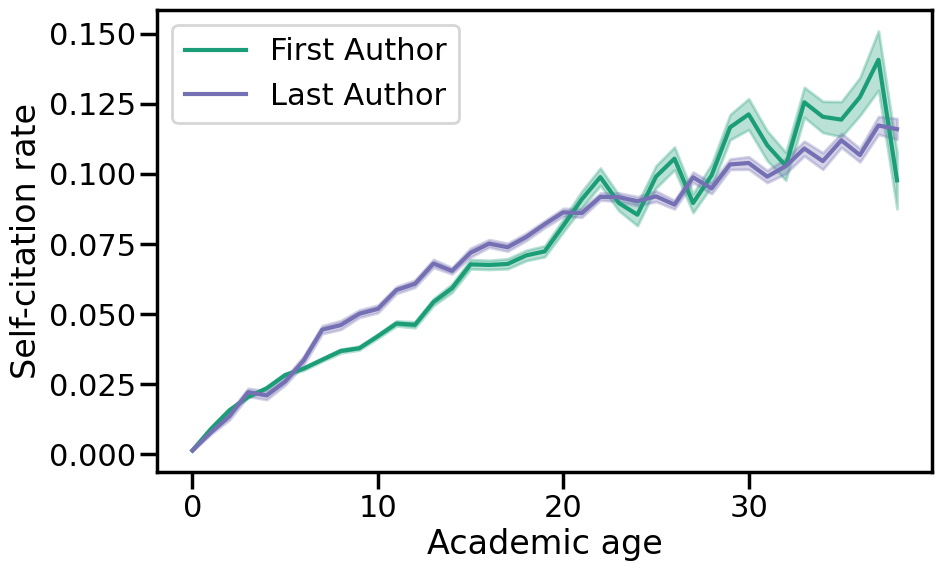

In [35]:
# Make plots of first/last author self-citation rates vs academic age

# functions for finding quantiles from dataframes
def qlower(x):
    return x.quantile(0.25)
def qupper(x):
    return x.quantile(0.75)

# whether to plot as fraction of previous publication history or not
plot_type='standard'  # standard, normed
if plot_type=='normed':
    fa_ac_age_sc = dat['fa_ac_age_sc_normed']
    la_ac_age_sc = dat['la_ac_age_sc_normed']
    save_str = '_normed'
    y_ax_str = 'Normed self-citations'
else:
    fa_ac_age_sc = dat['fa_ac_age_sc']
    la_ac_age_sc = dat['la_ac_age_sc']
    save_str = ''
    y_ax_str = 'Self-citation rate'

# sum used to turn into one large list (dat contains list of lists)
fa_ac_age = np.sort(dat['ac_age_to_keep'])
nboot = np.shape(fa_ac_age_sc)[0]

la_ac_age = np.sort(dat['ac_age_to_keep'])




ac_age = np.tile(fa_ac_age, 2*nboot)
ac_age_sc = np.hstack((fa_ac_age_sc.ravel(), la_ac_age_sc.ravel()))

author_type = ['FA']*len(fa_ac_age_sc.ravel()) + ['LA']*len(la_ac_age_sc.ravel())

df_ac_age = pd.DataFrame(list(zip(ac_age, ac_age_sc, author_type)),
               columns =['ac_age', 'sc', 'author'])

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df_ac_age, x='ac_age', y='sc', ci=None, hue='author', palette=custom_palette[:2])

# find 95% CI with 2.5, 97.5% quantile
df_quantiles=df_ac_age[df_ac_age.author=='FA'].groupby(['ac_age']).agg({'sc': [qlower, qupper]})
ax.fill_between(df_quantiles.index, df_quantiles['sc']['qlower'], df_quantiles['sc']['qupper'], color=custom_palette[0], alpha=.3)

df_quantiles=df_ac_age[df_ac_age.author=='LA'].groupby(['ac_age']).agg({'sc': [qlower, qupper]})
ax.fill_between(df_quantiles.index, df_quantiles['sc']['qlower'], df_quantiles['sc']['qupper'], color=custom_palette[1], alpha=.3)

# set labels and legends
ax.legend(labels=['First Author', 'Last Author'])
ax.set_xlabel('Academic age')
ax.set_ylabel(y_ax_str)



In [36]:
# print out actual numbers of self-citation rates at various academic ages
a = df_ac_age.groupby(['author', 'ac_age'], as_index=False).agg({'sc':'mean'})
a[a.ac_age.isin(np.arange(0, 31, 5))]

,author,ac_age,sc
0,FA,0,0.001257
5,FA,5,0.028193
10,FA,10,0.042061
15,FA,15,0.067701
20,FA,20,0.081465
25,FA,25,0.099020
30,FA,30,0.121255
39,LA,0,0.001250
44,LA,5,0.025860
49,LA,10,0.051800


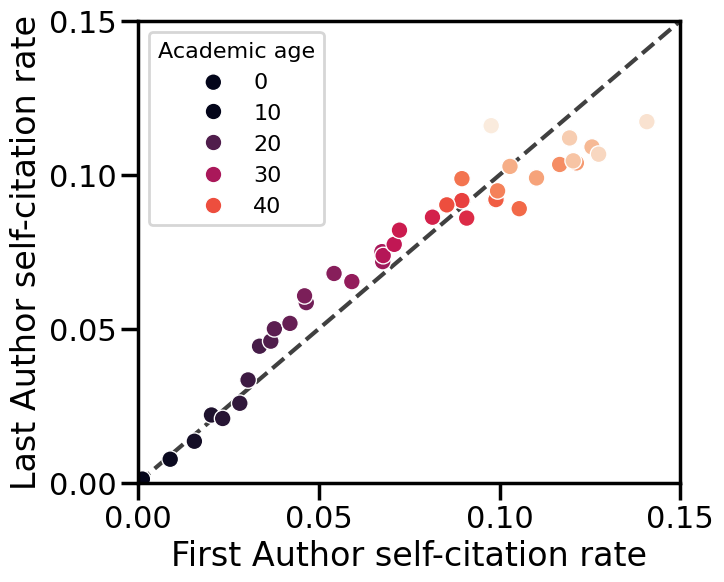

In [38]:
# Compare last author vs first author self-citation rates for each academic age

df_ac_age_fa = df_ac_age[df_ac_age['author']=='FA'].groupby('ac_age', as_index=False).agg({'sc':'mean'})
df_ac_age_la = df_ac_age[df_ac_age['author']=='LA'].groupby('ac_age', as_index=False).agg({'sc':'mean'})

df_ac_age_fa_vs_la = df_ac_age_fa.merge(df_ac_age_la, left_on='ac_age', right_on='ac_age')

fig, ax = plt.subplots(figsize=(7, 6))
sns.scatterplot(data=df_ac_age_fa_vs_la, x='sc_x', y='sc_y', ax=ax, hue='ac_age', palette = "rocket")
ax.set_xlabel('First author')
ax.set_ylabel('Last author')
ax.set_xlim([0, 0.15])
ax.set_ylim([0, 0.15])
ax.set_xticks([0, 0.05, 0.1, 0.15])
ax.set_yticks([0, 0.05, 0.1, 0.15])

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)

# set legend
ax.set_xlabel('First Author self-citation rate')
ax.set_ylabel('Last Author self-citation rate')
ax.legend(title='Academic age', title_fontsize=16, labels=[0, 10, 20, 30, 40], fontsize=16)


# Figure 3 - Country

In [40]:
# load in from base dataframe
df_countries = df[(df.affil_country.isin(dat['fa_countries_to_keep'])) & (df['SC Type']=='FA')]  # keep first author data with countries
df_countries = pd.concat([df_countries, (df[(df.affil_country.isin(dat['la_countries_to_keep'])) & (df['SC Type']=='LA')])])  # add in last author data with countries
df_country_summary = df_countries.groupby(['SC Type', 'affil_country'],
                                          as_index=False).agg({'numref':'sum', 'sc_count':'sum', 'numpapers':'sum'})
df_country_summary['sum_perc'] = df_country_summary['sc_count'] / df_country_summary['numref']
df_country_summary = df_country_summary.sort_values(by=['affil_country'], ascending=True)  # sort to match existing list order


Text(0.5, 1.0, 'First Author self-citation rates by country, min. 50 papers')

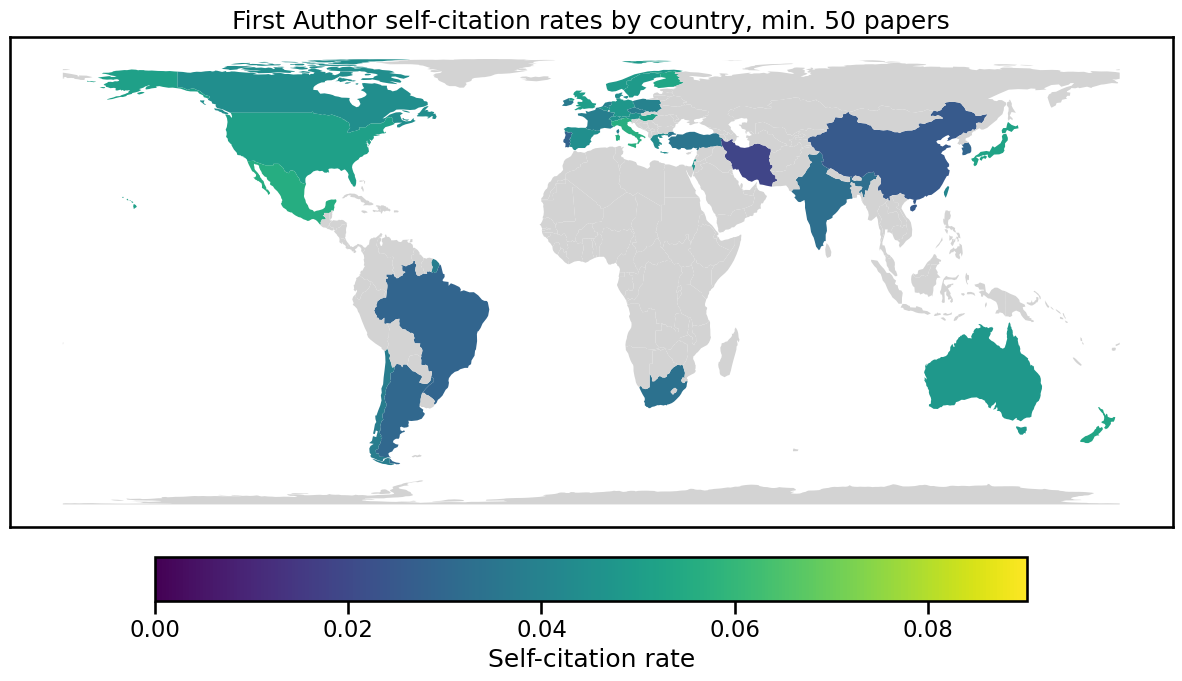

In [41]:
sns.set_context('talk')
# Plot map for first and/or last authors (change plot_type variable)
plot_type = 'FA'  # RUN FOR FA AND LA
paper_thresh = 50 # see boot code above
if plot_type=='FA':
    title_str = 'First Author'
elif plot_type=='LA':
    title_str = 'Last Author'
elif plot_type=='Any':
    title_str = 'Any Author'

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name=='France', 'iso_a3'] = 'FRA'  # fix france error where iso_a3 is excluded
df_plot = df_country_summary[df_country_summary['SC Type']==plot_type]
world = world.merge(df_plot, how='left', left_on=['iso_a3'], right_on=['affil_country'])
fig, ax = plt.subplots(figsize=(15, 8))
# cbar = plt.colorbar()
world = world.to_crs(epsg=6933)
world.plot(column='sum_perc', ax=ax, missing_kwds={'color': 'lightgrey'},
           legend=True,
           cmap='viridis', vmin=0, vmax=df_country_summary['sum_perc'].max(),
           legend_kwds={"label": "Self-citation rate",
                        "orientation": "horizontal", "pad":0.05,
                       "shrink":0.75})
ax.set_xticks([]); ax.set_yticks([])


ax.set_title(title_str + ' self-citation rates by country, min. ' + str(paper_thresh) + ' papers', fontsize=18)


Print out some summary stats

In [42]:
auth_type = 'la'
print('*************{:s}*************'.format(auth_type.upper()))
pd.DataFrame({'country': dat[auth_type+'_countries_to_keep'],
              'sc_median': np.median(dat[auth_type+'_sc_rate_country'], axis=0),
              'sc_lower': np.percentile(dat[auth_type+'_sc_rate_country'], q=2.5, axis=0),
              'sc_upper': np.percentile(dat[auth_type+'_sc_rate_country'], q=97.5, axis=0) })

*************LA*************


,country,sc_median,sc_lower,sc_upper
0,ARG,0.071128,0.057167,0.083546
1,AUS,0.075393,0.069588,0.079327
2,AUT,0.087282,0.072401,0.096249
3,BEL,0.075766,0.065770,0.082080
4,BRA,0.063678,0.055480,0.069842
5,CAN,0.078497,0.075496,0.081261
6,CHE,0.077229,0.073125,0.081804
7,CHL,0.083659,0.053684,0.095728
8,CHN,0.048435,0.045130,0.052048
9,CZE,0.048475,0.036725,0.061601


In [43]:
df_country_summary[df_country_summary['SC Type']=='LA'].sort_values(by='sum_perc')

,SC Type,affil_country,numref,sc_count,numpapers,sum_perc
72,LA,TUR,7441,206,187,0.027684
59,LA,IRN,3848,145,71,0.037682
75,LA,ZAF,4034,191,82,0.047348
47,LA,CZE,3811,183,77,0.048019
46,LA,CHN,43256,2092,818,0.048363
57,LA,IND,10550,519,241,0.049194
69,LA,PRT,14099,759,211,0.053834
63,LA,KOR,24355,1328,602,0.054527
54,LA,GRC,9915,585,186,0.059002
68,LA,POL,9086,573,184,0.063064


Text(0.5, 1.0, 'Normed self-citations for First Authors by country, min. 50 papers')

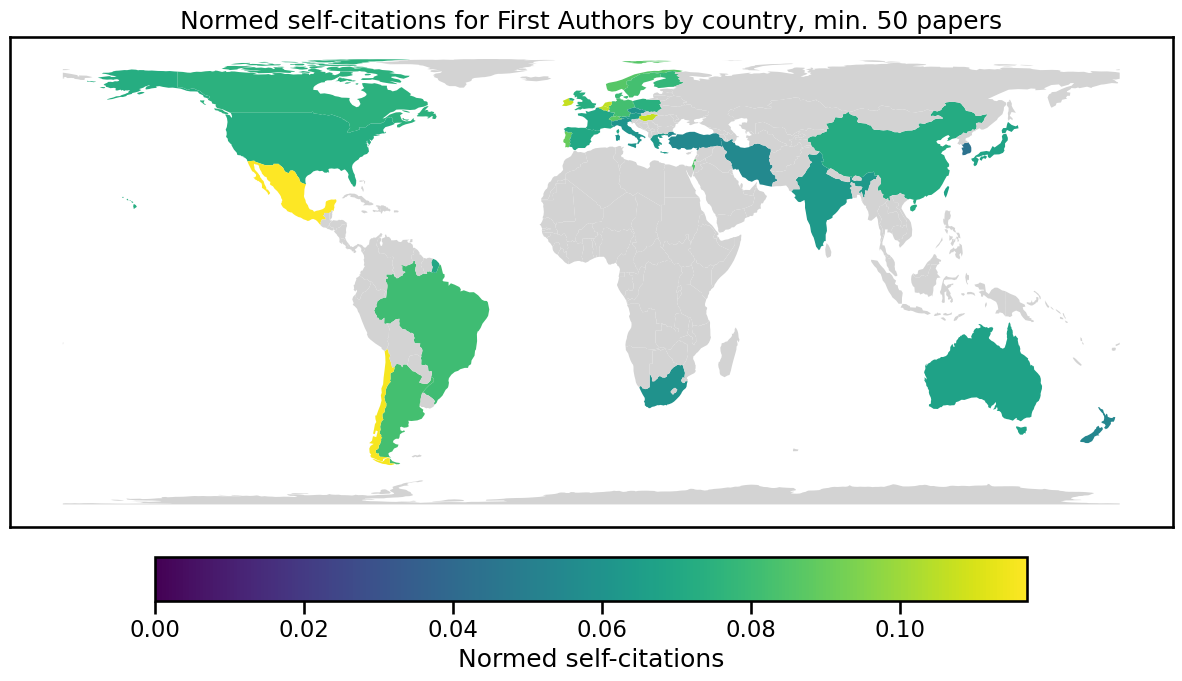

In [47]:
'''
Additional plots for country maps by
1) Impact factor
2) Number of previous papers
'''
plot_type = 'FA'  # RUN FOR FA AND LA
plot_var = 'sc_normed'  # journal_citing_if, papers_before_by_date, sc_normed

# load in from base dataframe
df_countries = df[(df.affil_country.isin(dat['fa_countries_to_keep'])) & (df['SC Type']=='FA')]  # keep first author data with countries
df_countries = pd.concat([df_countries, df[(df.affil_country.isin(dat['la_countries_to_keep'])) & (df['SC Type']=='LA')]])  # add in last author data with countries
df_country_summary = df_countries.groupby(['SC Type', 'affil_country'],
                                          as_index=False).agg({'numref':'sum', 'sc_count':'sum', 'numpapers':'sum',
                                                              'journal_citing_if':'mean', 'papers_before_by_date':'mean'})
df_country_summary['sum_perc'] = df_country_summary['sc_count'] / df_country_summary['numref']
df_country_summary['sc_normed'] = df_country_summary['sc_count'] / df_country_summary['papers_before_by_date'] / df_country_summary['numpapers']
df_country_summary = df_country_summary.sort_values(by=['affil_country'], ascending=True)  # sort to match existing list order

paper_thresh = 50 # see boot code above
if plot_type=='FA':
    title_auth_str = 'First Authors'
elif plot_type=='LA':
    title_auth_str = 'Last Authors'

if plot_var=='journal_citing_if':
    title_var_str = 'Mean impact factor'
elif plot_var=='papers_before_by_date':
    title_var_str = 'Mean # previous papers'
elif plot_var=='sc_normed':
    title_var_str = 'Normed self-citations'

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name=='France', 'iso_a3'] = 'FRA'  # fix france error where iso_a3 is excluded
df_plot = df_country_summary[df_country_summary['SC Type']==plot_type]
world = world.merge(df_plot, how='left', left_on=['iso_a3'], right_on=['affil_country'])
fig, ax = plt.subplots(figsize=(15, 8))
world = world.to_crs(epsg=6933)
world.plot(column=plot_var, ax=ax, missing_kwds={'color': 'lightgrey'},
           legend=True,
           cmap='viridis', vmin=0, vmax=df_country_summary[plot_var].max(),
           legend_kwds={"label": title_var_str,
                        "orientation": "horizontal", "pad":0.05,
                        "shrink":0.75})
ax.set_xticks([]); ax.set_yticks([])

ax.set_title('{:s} for {:s} by country, min. {:d} papers'.format(title_var_str, title_auth_str, paper_thresh), fontsize=18)


In [48]:
# Spearman correlation between self-citation rate, previous papers, and impact factor (averaged over country)
df_plot[['sum_perc', 'papers_before_by_date', 'journal_citing_if']].corr(method='spearman')

,sum_perc,papers_before_by_date,journal_citing_if
sum_perc,1.000000,0.576102,0.156801
papers_before_by_date,0.576102,1.000000,0.001422
journal_citing_if,0.156801,0.001422,1.000000


# Figure 4 - topics

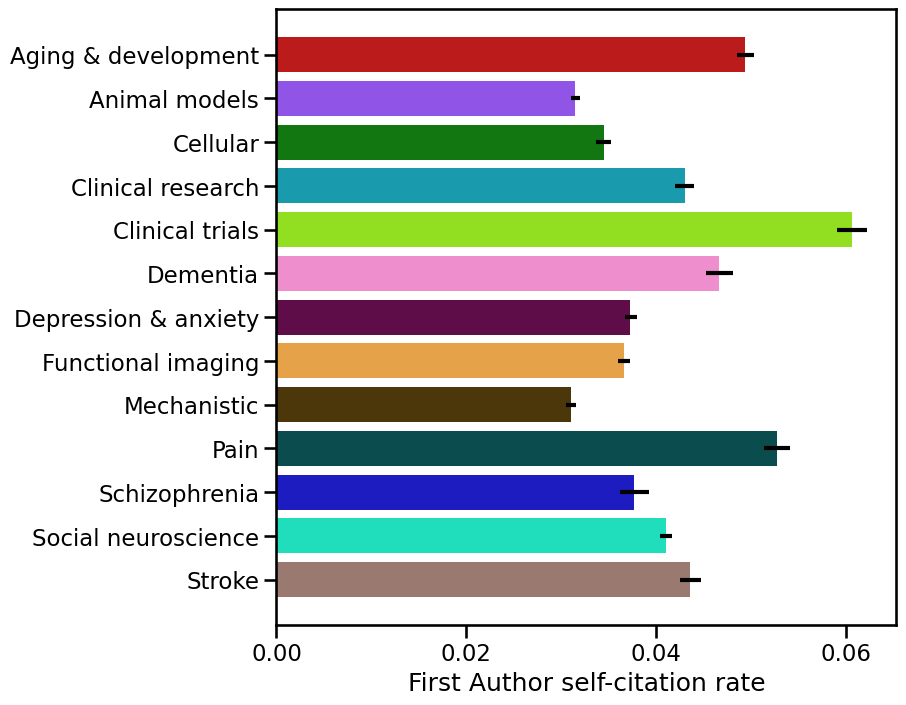

In [49]:
# plot self-citation rate by number of topics
author_type = 'FA'  # change to FA, LA, or Any
num_topics = 13

if author_type=='FA':
    title_str = 'First Author'
elif author_type=='LA':
    title_str = 'Last Author'
elif author_type=='Any':
    title_str = 'Any Author'


# functions for finding quantiles from dataframes
def qlower(x):
    return x.quantile(0.25)
def qupper(x):
    return x.quantile(0.75)

topic_fa_sc=dat['topic_fa_sc']
topic_la_sc=dat['topic_la_sc']
topic_any_sc=dat['topic_any_sc']

topic_names = np.array(['Clinical research', 'Aging & development', 'Dementia', 'Functional imaging',
               'Pain', 'Animal models', 'Stroke', 'Clinical trials', 'Schizophrenia', 'Cellular',
               'Mechanistic', 'Depression & anxiety', 'Social neuroscience'])
alphabetical_order = np.argsort(topic_names)
ntopics = len(topic_names)

topic_sc_array = np.array([])
auth_array = np.array([])
topic_id_array = np.array([])
num_boot_iters = np.shape(topic_fa_sc)[0]
for i in range(ntopics):
    topic_sc_array = np.concatenate([topic_sc_array, topic_fa_sc[:, i], topic_la_sc[:, i], topic_any_sc[:, i]])
    auth_array = np.concatenate([auth_array, num_boot_iters*['FA'], num_boot_iters*['LA'], num_boot_iters*['Any']])
    # topic_id_array = np.concatenate([topic_id_array, 3*num_boot_iters*[i]])
    topic_id_array = np.concatenate([topic_id_array, 3*num_boot_iters*[topic_names[i]]])

df_topics = pd.DataFrame({'topic':topic_id_array, 'auth':auth_array, 'sc':topic_sc_array})
df_topics = df_topics.sort_values('topic')

fig, ax = plt.subplots(figsize=(8, 8))
many_palette = sns.color_palette(cc.glasbey, n_colors=num_topics)
sns.barplot(data=df_topics[df_topics['auth']==author_type], y='topic', x='sc', ci=None, orient='h', ax=ax, palette=many_palette)

# get quantiles for CI, then add error bars
df_quantiles = df_topics[df_topics.auth==author_type].groupby(['topic']).agg({'sc': [qlower, qupper, 'median']})
df_mean = df_topics[df_topics.auth==author_type].groupby(['topic']).agg({'sc': 'mean'})
ci_vals = np.zeros((2, 13))
ci_vals[0, :] = np.abs(df_quantiles['sc']['qlower'] - df_mean['sc'])
ci_vals[1, :] = df_quantiles['sc']['qupper'] - df_mean['sc']
ax.errorbar(x=df_mean.sc, y=np.arange(0, 13), xerr=ci_vals, ls='', lw=3, color='black')

# axis labels
ax.set_ylabel('')
if author_type!='FA':  # remove tick labels for first author
    ax.set_yticks([])
ax.set_xlabel('{:s} self-citation rate'.format(title_str))

# 3 ticks
ax.xaxis.set_major_locator(plt.MaxNLocator(4))

## topic and gender

In [50]:
import matplotlib.colors as mc
import colorsys
def lighten_color(color, amount=0.5):
    """
    From: https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """

    try:
        c = mc.cnames[color]
    except:
        c = color

    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

<ipython-input-57-b4c85460c6f7>:64: UserWarning: The palette list has more values (13) than needed (2), which may not be intended.
  sns.barplot(data=df_topics[df_topics['auth']==author_type],


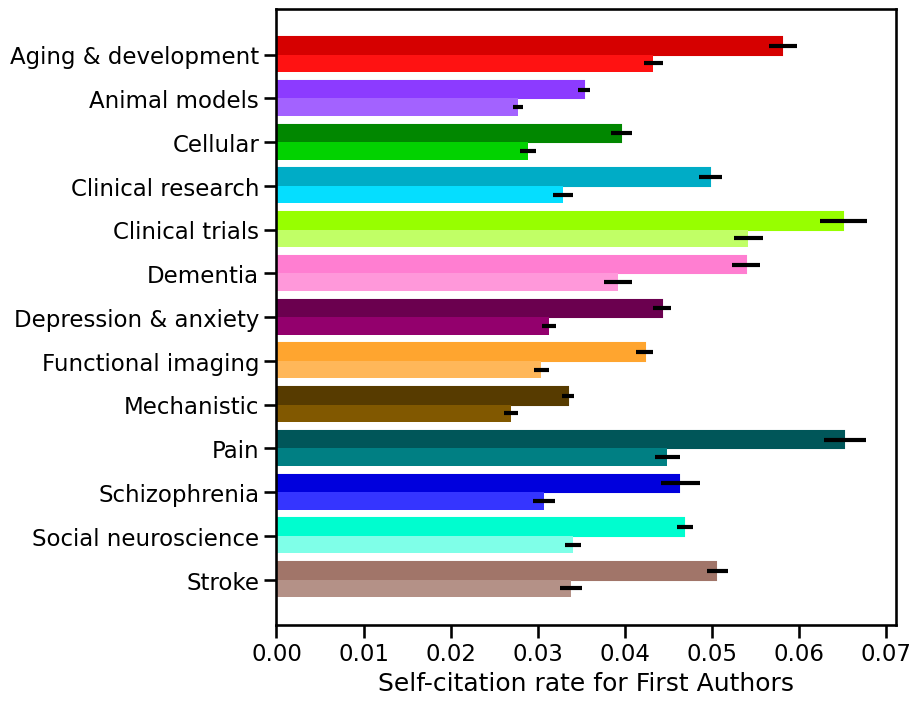

In [57]:
# Makes plot of gender proportions for each topic
plot_var = 'sc'  # gender_proportion, sc
author_type = 'FA'  # FA, LA, Any
auth_type_name_dict = {'FA': 'First Authors', 'LA':'Last Authors'}
num_topics = 13
from seaborn.utils import ci
import colorcet as cc

# functions for finding quantiles from dataframes
def qlower(x):
    return x.quantile(0.25)
def qupper(x):
    return x.quantile(0.75)

# get proportion values
topic_fa_proportion_female=dat['perc_female_fa_la_topic'][:, :, 0]
topic_la_proportion_female=dat['perc_female_fa_la_topic'][:, :, 1]
topic_fa_proportion_male=1-topic_fa_proportion_female
topic_la_proportion_male=1-topic_la_proportion_female

# get self-citation values
topic_fa_sc_female=dat['topic_gender_sc_fa_female']
topic_la_sc_female=dat['topic_gender_sc_la_female']
topic_fa_sc_male=dat['topic_gender_sc_fa_male']
topic_la_sc_male=dat['topic_gender_sc_la_male']

# get and sort topic names (see Drive for order)
topic_names = np.array(['Clinical research', 'Aging & development', 'Dementia', 'Functional imaging',
               'Pain', 'Animal models', 'Stroke', 'Clinical trials', 'Schizophrenia', 'Cellular',
               'Mechanistic', 'Depression & anxiety', 'Social neuroscience'])
alphabetical_order = np.argsort(topic_names)
ntopics = len(topic_names)

# initialize empty arrays
topic_proportion_array = np.array([])
topic_sc_array = np.array([])
auth_array = np.array([])
gender_array = np.array([])
topic_id_array = np.array([])

# loop over iterations
num_boot_iters = np.shape(topic_fa_sc)[0]
for i in range(ntopics):
    # get gender proportion
    topic_proportion_array = np.concatenate([topic_proportion_array, topic_fa_proportion_female[:, i], topic_fa_proportion_male[:, i],
                                   topic_la_proportion_female[:, i], topic_la_proportion_male[:, i]])

    # get gender sc rate
    topic_sc_array = np.concatenate([topic_sc_array, topic_fa_sc_female[:, i], topic_fa_sc_male[:, i],
                                   topic_la_sc_female[:, i], topic_la_sc_male[:, i]])

    # get additional information
    auth_array = np.concatenate([auth_array, num_boot_iters*['FA'], num_boot_iters*['FA'], num_boot_iters*['LA'], num_boot_iters*['LA']])
    gender_array = np.concatenate([gender_array, num_boot_iters*['Woman'], num_boot_iters*['Man'], num_boot_iters*['Woman'], num_boot_iters*['Man']])
    topic_id_array = np.concatenate([topic_id_array, 4*num_boot_iters*[topic_names[i]]])

# make into dataframe
df_topics = pd.DataFrame({'topic':topic_id_array, 'auth':auth_array, 'gender':gender_array,
                          'gender_proportion':topic_proportion_array, 'sc':topic_sc_array})
df_topics = df_topics.sort_values('topic')

fig, ax = plt.subplots(figsize=(8, 8))
many_palette = sns.color_palette(cc.glasbey, n_colors=num_topics)
sns.barplot(data=df_topics[df_topics['auth']==author_type],
            y='topic', x=plot_var, hue='gender',
            ci=None, orient='h', ax=ax, palette=many_palette)

# make lighter palette for certain bars
lighter_palette = sns.color_palette(cc.glasbey, n_colors=num_topics)
lighten_amounts = [0.8, 0.8, 0.8, 0.8, 0.6, 0.8, 0.9, 0.8, 0.9, 0.9, 0.7, 0.5, 0.8]
for i in range(len(many_palette)):
    lighter_palette[i] = lighten_color(many_palette[i], amount=lighten_amounts[i])
for i, bar in enumerate(ax.patches[:(num_topics*2)]):
    if i>=num_topics:
        palette_idx = i-num_topics
        bar.set_facecolor(lighter_palette[palette_idx])
        # bar.set_hatch('\\')
    else:
        palette_idx = i
        bar.set_color(many_palette[palette_idx])


df_quantiles = df_topics[df_topics.auth==author_type].groupby(['topic', 'gender'],
                                                              as_index=False).agg({plot_var: [qlower, qupper]})
df_mean = df_topics[df_topics.auth==author_type].groupby(['topic', 'gender'],
                                                         as_index=False).agg({plot_var: 'mean'})
ci_vals = np.zeros((2, 2*num_topics))
ci_vals[0, :] = np.abs(df_quantiles[plot_var]['qlower'] - df_mean[plot_var])
ci_vals[1, :] = df_quantiles[plot_var]['qupper'] - df_mean[plot_var]

# add two legends
# h,l = ax.get_legend_handles_labels() ##Get the legend handles and lables
# l1 = ax.legend(h[:int(len(h)/2)],l[:int(len(l)/2)], loc='upper left',bbox_to_anchor=(1.01,1)) ##Plot half as the first legend

# from matplotlib.container import BarContainer
# myHandle = [BarContainer(color='red'),  BarContainer(color='green')] ##Create custom handles for 2nd legend
# l2 = ax.legend(handles=myHandle, labels = ['Neuroscience', 'Nature Neuroscience'],
#                loc='upper left', bbox_to_anchor=(1.01, 0.6),) ##Add 2nd legend


# make array with locations of errorbars
y1 = np.arange(-.2, num_topics-.2, 1)
y2 = np.arange(0.2, num_topics-.2, 1)
y = np.zeros((len(y1) + len(y2)), )
y[::2] = y1; y[1::2] = y2
ax.errorbar(x=df_mean[plot_var], y=y,
            xerr=ci_vals, ls='', lw=3, color='black')

# update legend colors
if author_type=='LA':
    leg = ax.get_legend()
    leg.legendHandles[0].set_color('#636363')
    leg.legendHandles[1].set_color('#bdbdbd')
    leg.set_title('')
    leg.set_bbox_to_anchor((1.01, 1))

    ax.set_yticklabels([])
else:
    ax.get_legend().remove()

# set labels
ax.set_ylabel('')
if plot_var=='gender_proportion':
    ax.set_xlabel('Proportion of {:s}'.format(auth_type_name_dict[author_type]))
else:
    ax.set_xlabel('Self-citation rate for {:s}'.format(auth_type_name_dict[author_type]))


# Figure 5 - gender

In [58]:
# Print bootstrap results: compare sc rates for men/women
print('Men FA sc in 2020: ' + '{:.6f}'.format(np.mean(dat['time_gender_sc_fa_male'][:, -1])) +
      ' (' + '{:.6f}'.format(np.percentile(dat['time_gender_sc_fa_male'][:, -1], q=2.5)) + ', '
      '{:.6f}'.format(np.percentile(dat['time_gender_sc_fa_male'][:, -1], q=97.5)) + ')')
print('Women FA sc in 2020: ' + '{:.6f}'.format(np.mean(dat['time_gender_sc_fa_female'][:, -1])) +
      ' (' + '{:.6f}'.format(np.percentile(dat['time_gender_sc_fa_female'][:, -1], q=2.5)) + ', '
      '{:.6f}'.format(np.percentile(dat['time_gender_sc_fa_female'][:, -1], q=97.5)) + ')')
# print(calc_pval(dat['time_gender_sc_fa_male'][:, -1], dat['time_gender_sc_fa_female'][:, -1]))


print('Men LA sc in 2020: ' + '{:.6f}'.format(np.mean(dat['time_gender_sc_la_male'][:, -1])) +
      ' (' + '{:.6f}'.format(np.percentile(dat['time_gender_sc_la_male'][:, -1], q=2.5)) + ', '
      '{:.6f}'.format(np.percentile(dat['time_gender_sc_la_male'][:, -1], q=97.5)) + ')')
print('Women LA sc in 2020: ' + '{:.6f}'.format(np.mean(dat['time_gender_sc_la_female'][:, -1])) +
      ' (' + '{:.6f}'.format(np.percentile(dat['time_gender_sc_la_female'][:, -1], q=2.5)) + ', '
      '{:.6f}'.format(np.percentile(dat['time_gender_sc_la_female'][:, -1], q=97.5)) + ')')
# print(calc_pval(dat['time_gender_sc_la_male'][:, -1], dat['time_gender_sc_la_female'][:, -1]))


Men FA sc in 2020: 0.041155 (0.039094, 0.042874)
Women FA sc in 2020: 0.032360 (0.030574, 0.034080)
Men LA sc in 2020: 0.079313 (0.076419, 0.081629)
Women LA sc in 2020: 0.070896 (0.067805, 0.073610)


## time author proportion

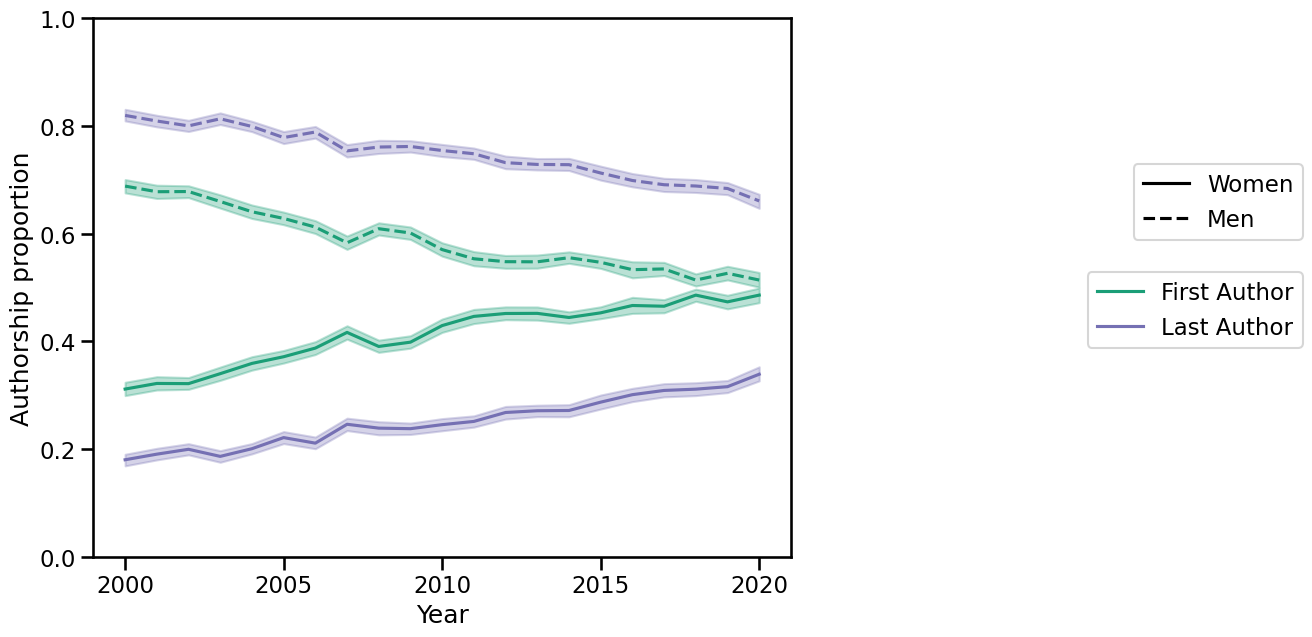

In [59]:
# Plot proportion of men/womenauthors over time
gender_palette = ['#0b03fc', '#fceb03']
gender_style = ['-', '--']

fa_gender_ratio = dat['time_gender_sc_fa_male'] / dat['time_gender_sc_fa_female']
fa_lower = np.percentile(dat['time_gender_proportion_fa_female'], q=2.5, axis=0)
fa_upper = np.percentile(fa_gender_ratio, q=97.5, axis=0)

la_gender_ratio = dat['time_gender_sc_la_male'] / dat['time_gender_sc_la_female']
la_lower = np.percentile(la_gender_ratio, q=2.5, axis=0)
la_upper = np.percentile(la_gender_ratio, q=97.5, axis=0)

years = np.arange(2000, 2021)

fig, ax = plt.subplots(figsize=(9, 7))

# for first author woman
ax.plot(years, np.mean(dat['time_gender_proportion_fa_female'], axis=0), color=custom_palette[0], label='Woman FA', linestyle=gender_style[0])
ax.fill_between(years, np.percentile(dat['time_gender_proportion_fa_female'], q=2.5, axis=0),
                np.percentile(dat['time_gender_proportion_fa_female'], q=97.5, axis=0),
                color=custom_palette[0], alpha=.3)

# for first author man
ax.plot(years, np.mean(dat['time_gender_proportion_fa_male'], axis=0), color=custom_palette[0], label='Man FA', linestyle=gender_style[1])
ax.fill_between(years, np.percentile(dat['time_gender_proportion_fa_male'], q=2.5, axis=0),
                np.percentile(dat['time_gender_proportion_fa_male'], q=97.5, axis=0),
                color=custom_palette[0], alpha=.3)

# for last author woman
ax.plot(years, np.mean(dat['time_gender_proportion_la_female'], axis=0), color=custom_palette[1], label='Woman LA', linestyle=gender_style[0])
ax.fill_between(years, np.percentile(dat['time_gender_proportion_la_female'], q=2.5, axis=0),
                np.percentile(dat['time_gender_proportion_la_female'], q=97.5, axis=0),
                color=custom_palette[1], alpha=.3)

# for last author man
ax.plot(years, np.mean(dat['time_gender_proportion_la_male'], axis=0), color=custom_palette[1], label='Man LA', linestyle=gender_style[1])
ax.fill_between(years, np.percentile(dat['time_gender_proportion_la_male'], q=2.5, axis=0),
                np.percentile(dat['time_gender_proportion_la_male'], q=97.5, axis=0),
                color=custom_palette[1], alpha=.3)

plt.xlabel('Year')
plt.ylabel('Authorship proportion')
ax.set_ylim([0, 1])
ax.set_xticks([2000, 2005, 2010, 2015, 2020])

# modify legends / custom legends: see https://matplotlib.org/stable/users/explain/axes/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
fa_line = matplotlib.lines.Line2D([], [], color=custom_palette[0], label='First Author')
la_line = matplotlib.lines.Line2D([], [], color=custom_palette[1], label='Last Author')
leg1 = ax.legend(handles=[fa_line, la_line], bbox_to_anchor=(1.75, .55))
ax.add_artist(leg1)
w_line = matplotlib.lines.Line2D([], [], color='black', linestyle='-', label='Women')
m_line = matplotlib.lines.Line2D([], [], color='black', linestyle='--', label='Men')
ax.legend(handles=[w_line, m_line], bbox_to_anchor=(1.75, .75))


In [60]:
print(dat['time_gender_proportion_fa_female'].mean(axis=0))

[0.31173326 0.32214619 0.32180512 0.34028312 0.35931873 0.3717181
 0.38774001 0.41685436 0.39077183 0.39874448 0.4295231  0.44655353
 0.45194469 0.45217891 0.44453246 0.45314575 0.46675971 0.46541068
 0.48601991 0.47350237 0.4860176 ]


In [61]:
# assess convergence of authorship proportions with CIs
nboot = np.shape(dat['time_gender_proportion_fa_female'])[0]
projection_fa = np.zeros((nboot,))
projection_la = np.zeros((nboot,))
year_range = np.arange(21)
# loop over all bootstrap iterations
for i in range(nboot):
    # regression lines for men and women first authors
    regr_fa_female = linregress(year_range, dat['time_gender_proportion_fa_female'][i, :])
    regr_fa_male = linregress(year_range, dat['time_gender_proportion_fa_male'][i, :])
    # find interesection point
    projection_fa[i] = (regr_fa_male.intercept - regr_fa_female.intercept) / (regr_fa_female.slope - regr_fa_male.slope)

    # regression lines for men and women last authors
    regr_la_female = linregress(year_range, dat['time_gender_proportion_la_female'][i, :])
    regr_la_male = linregress(year_range, dat['time_gender_proportion_la_male'][i, :])
    # find intersection point
    projection_la[i] = (regr_la_male.intercept - regr_la_female.intercept) / (regr_la_female.slope - regr_la_male.slope)

print('For first authors: ' + '{:.2f}'.format(np.mean(projection_fa)) + ' (' + '{:.2f}'.format(np.percentile(projection_fa, q=2.5)) +\
      ', ' + '{:.2f}'.format(np.percentile(projection_fa, q=97.5)) + ')')
print('For last authors: ' + '{:.2f}'.format(np.mean(projection_la)) + ' (' + '{:.2f}'.format(np.percentile(projection_la, q=2.5)) +\
      ', ' + '{:.2f}'.format(np.percentile(projection_la, q=97.5)) + ')')

For first authors: 19.77 (18.85, 20.79)
For last authors: 43.10 (40.13, 46.20)


## ratio of self-citation rates of men to women over time

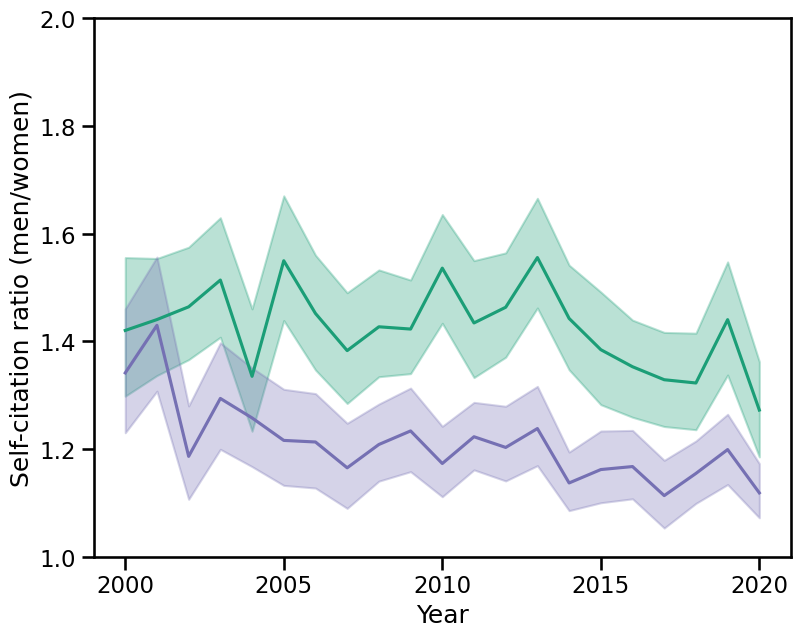

In [62]:
# plot ratio of self-citation rates by gender over time
fa_gender_ratio = dat['time_gender_sc_fa_male'] / dat['time_gender_sc_fa_female']
fa_lower = np.percentile(fa_gender_ratio, q=2.5, axis=0)
fa_upper = np.percentile(fa_gender_ratio, q=97.5, axis=0)

la_gender_ratio = dat['time_gender_sc_la_male'] / dat['time_gender_sc_la_female']
la_lower = np.percentile(la_gender_ratio, q=2.5, axis=0)
la_upper = np.percentile(la_gender_ratio, q=97.5, axis=0)

years = np.arange(2000, 2021)

fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(years, np.mean(fa_gender_ratio, axis=0), color=custom_palette[0], label='First author')
ax.fill_between(years, fa_lower, fa_upper, color=custom_palette[0], alpha=.3)


ax.plot(years, np.mean(la_gender_ratio, axis=0), color=custom_palette[1], label='Last author')
ax.fill_between(years, la_lower, la_upper, color=custom_palette[1], alpha=.3)

# plt.legend()
plt.xlabel('Year')
plt.ylabel('Self-citation ratio (men/women)')
ax.set_ylim([1, 2])
ax.set_xticks([2000, 2005, 2010, 2015, 2020])

In [63]:
# show range of gender self-citation rate ratios for first aurhotrs
mean_fa_ratios_by_year = np.mean(fa_gender_ratio, axis=0)
print('Lowest gender sc ratio for first authors: {:.4f} and highest {:.4f}'.format(np.min(mean_fa_ratios_by_year), np.max(mean_fa_ratios_by_year)))


# for last authors
mean_la_ratios_by_year = np.mean(la_gender_ratio, axis=0)
print('Lowest gender sc ratio for last authors: {:.4f} and highest {:.4f}'.format(np.min(mean_la_ratios_by_year), np.max(mean_la_ratios_by_year)))

mean_la_ratios_by_year = np.mean(la_gender_ratio, axis=0)[2:]
print('Excluding first 2 years, lowest gender sc ratio for last authors: {:.4f} and highest {:.4f}'.format(np.min(mean_la_ratios_by_year), np.max(mean_la_ratios_by_year)))

Lowest gender sc ratio for first authors: 1.2727 and highest 1.5557
Lowest gender sc ratio for last authors: 1.1141 and highest 1.4300
Excluding first 2 years, lowest gender sc ratio for last authors: 1.1141 and highest 1.2943


## time gender sc

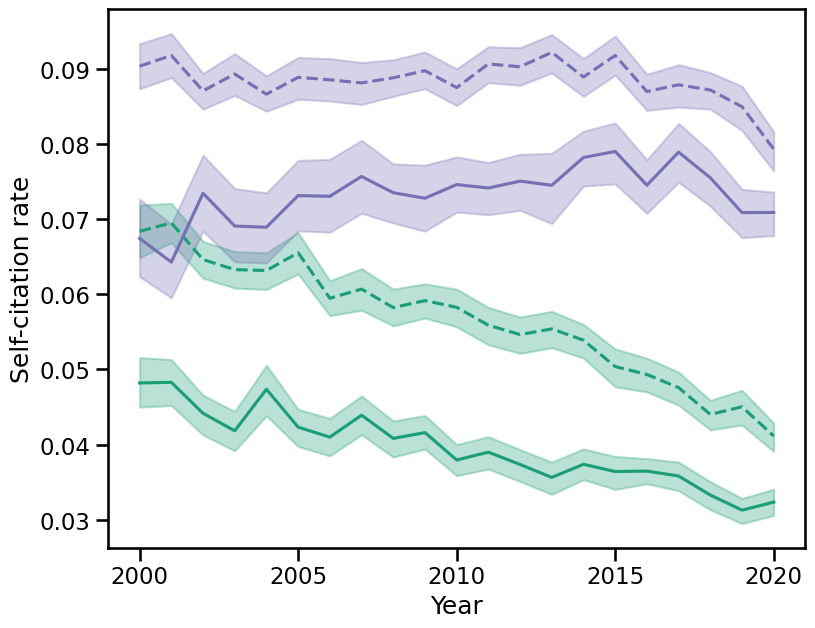

In [64]:
# plot gender self-citation rates over time
gender_palette = ['#0b03fc', '#fceb03']
gender_style = ['-', '--']

years = np.arange(2000, 2021)

fig, ax = plt.subplots(figsize=(9, 7))

# for first author woman
ax.plot(years, np.mean(dat['time_gender_sc_fa_female'], axis=0), color=custom_palette[0], label='Woman FA', linestyle=gender_style[0])
ax.fill_between(years, np.percentile(dat['time_gender_sc_fa_female'], q=2.5, axis=0),
                np.percentile(dat['time_gender_sc_fa_female'], q=97.5, axis=0),
                color=custom_palette[0], alpha=.3)

# for first author man
ax.plot(years, np.mean(dat['time_gender_sc_fa_male'], axis=0), color=custom_palette[0], label='Man FA', linestyle=gender_style[1])
ax.fill_between(years, np.percentile(dat['time_gender_sc_fa_male'], q=2.5, axis=0),
                np.percentile(dat['time_gender_sc_fa_male'], q=97.5, axis=0),
                color=custom_palette[0], alpha=.3)

# for last author woman
ax.plot(years, np.mean(dat['time_gender_sc_la_female'], axis=0), color=custom_palette[1], label='Woman LA', linestyle=gender_style[0])
ax.fill_between(years, np.percentile(dat['time_gender_sc_la_female'], q=2.5, axis=0),
                np.percentile(dat['time_gender_sc_la_female'], q=97.5, axis=0),
                color=custom_palette[1], alpha=.3)

# for last author man
ax.plot(years, np.mean(dat['time_gender_sc_la_male'], axis=0), color=custom_palette[1], label='Man LA', linestyle=gender_style[1])
ax.fill_between(years, np.percentile(dat['time_gender_sc_la_male'], q=2.5, axis=0),
                np.percentile(dat['time_gender_sc_la_male'], q=97.5, axis=0),
                color=custom_palette[1], alpha=.3)

# plt.legend()
plt.xlabel('Year')
plt.ylabel('Self-citation rate')
ax.set_xticks([2000, 2005, 2010, 2015, 2020])

# ax.set_ylim([0, 1])


In [65]:
# assess convergence of self-citation rates with CIs
nboot = np.shape(dat['time_gender_sc_fa_male'])[0]
projection_fa = np.zeros((nboot,))
projection_la = np.zeros((nboot,))
year_range = np.arange(21)

for i in range(nboot):
    regr_fa_female = linregress(year_range, dat['time_gender_sc_fa_female'][i, :])
    regr_fa_male = linregress(year_range, dat['time_gender_sc_fa_male'][i, :])
    projection_fa[i] = (regr_fa_male.intercept - regr_fa_female.intercept) / (regr_fa_female.slope - regr_fa_male.slope)

    regr_la_female = linregress(year_range, dat['time_gender_sc_la_female'][i, :])
    regr_la_male = linregress(year_range, dat['time_gender_sc_la_male'][i, :])
    projection_la[i] = (regr_la_male.intercept - regr_la_female.intercept) / (regr_la_female.slope - regr_la_male.slope)

print('For first authors: ' + '{:.2f}'.format(np.mean(projection_fa)) + ' (' + '{:.2f}'.format(np.percentile(projection_fa, q=2.5)) +\
      ', ' + '{:.2f}'.format(np.percentile(projection_fa, q=97.5)) + ')')
print('For last authors: ' + '{:.2f}'.format(np.mean(projection_la)) + ' (' + '{:.2f}'.format(np.percentile(projection_la, q=2.5)) +\
      ', ' + '{:.2f}'.format(np.percentile(projection_la, q=97.5)) + ')')

For first authors: 44.12 (35.74, 55.55)
For last authors: 40.19 (30.32, 60.51)


## gender ac age

Text(0, 0.5, 'Self-citation rate')

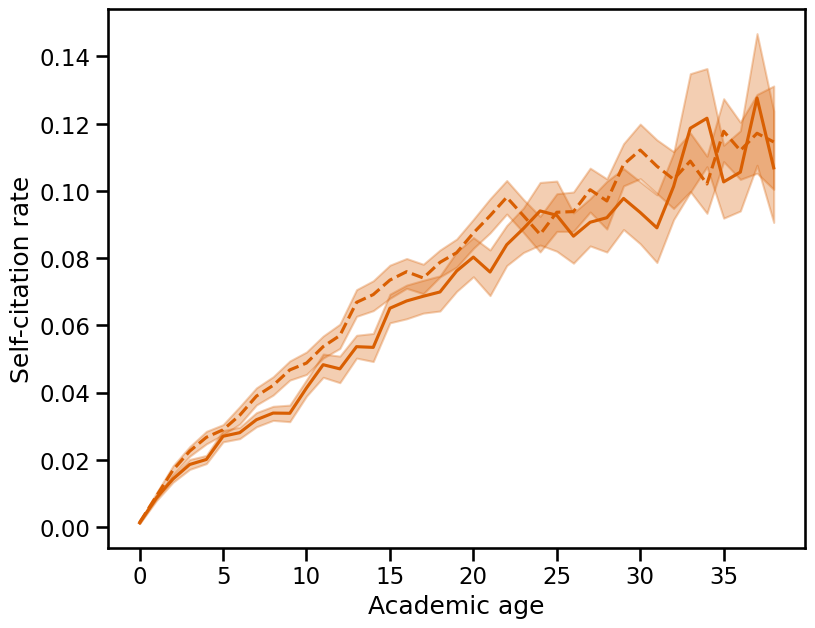

In [66]:
# make plots of self-citation rate vs academic age grouped by gender
gender_palette = ['#0b03fc', '#fceb03']
gender_style = ['-', '--']

ac_ages = np.arange(np.shape(dat['ac_age_gender_sc_male'])[1])

fig, ax = plt.subplots(figsize=(9, 7))

# for first author woman
ax.plot(ac_ages, np.mean(dat['ac_age_gender_sc_female'], axis=0), color=custom_palette[2], label='Woman', linestyle=gender_style[0])
ax.fill_between(ac_ages, np.percentile(dat['ac_age_gender_sc_female'], q=2.5, axis=0),
                np.percentile(dat['ac_age_gender_sc_female'], q=97.5, axis=0),
                color=custom_palette[2], alpha=.3)

# for first author man
ax.plot(ac_ages, np.mean(dat['ac_age_gender_sc_male'], axis=0), color=custom_palette[2], label='Man', linestyle=gender_style[1])
ax.fill_between(ac_ages, np.percentile(dat['ac_age_gender_sc_male'], q=2.5, axis=0),
                np.percentile(dat['ac_age_gender_sc_male'], q=97.5, axis=0),
                color=custom_palette[2], alpha=.3)

# plt.legend()
plt.xlabel('Academic age')
plt.ylabel('Self-citation rate')
# ax.set_ylim([0, 1])


## gender ac age ratio

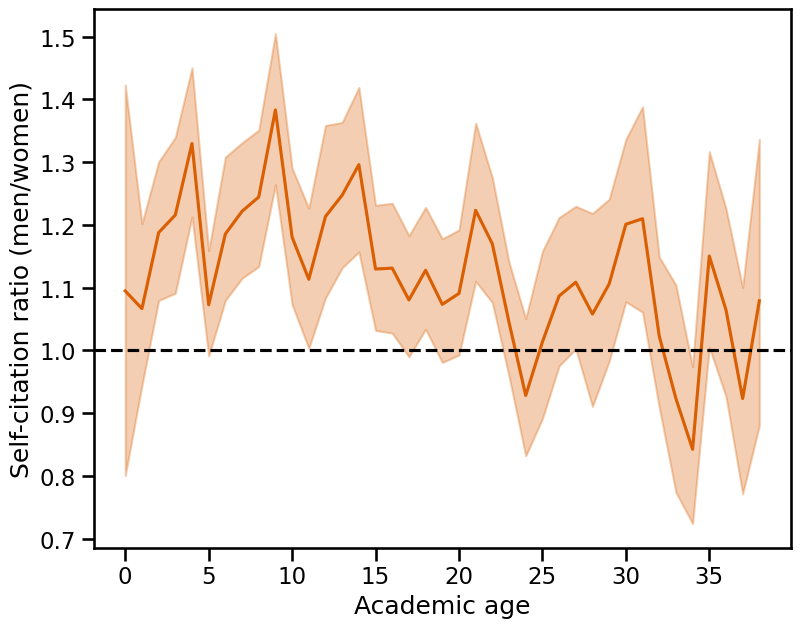

In [67]:
# ratio of self-citation rates of men to women for each academic age
gender_palette = ['#0b03fc', '#fceb03']
gender_style = ['-', '--']

ac_ages = np.arange(np.shape(dat['ac_age_gender_sc_male'])[1])
sc_ratio_ac_age = dat['ac_age_gender_sc_male'] / dat['ac_age_gender_sc_female']

fig, ax = plt.subplots(figsize=(9, 7))

# for first author woman
ax.plot(ac_ages, np.mean(sc_ratio_ac_age, axis=0), color=custom_palette[2])
ax.fill_between(ac_ages, np.percentile(sc_ratio_ac_age, q=2.5, axis=0),
                np.percentile(sc_ratio_ac_age, q=97.5, axis=0),
                color=custom_palette[2], alpha=.3)


plt.xlabel('Academic age')
plt.ylabel('Self-citation ratio (men/women)')
ax.axhline(y=1, color='black', linestyle='--')
# ax.set_ylim([0, 1])


In [68]:
# print out mean ratios by academic age (after running above)
np.mean(sc_ratio_ac_age, axis=0)

array([1.09470097, 1.06658911, 1.18758002, 1.21584349, 1.32972273,
       1.07271794, 1.1855529 , 1.22174614, 1.24444585, 1.38329295,
       1.18041373, 1.11329365, 1.21346322, 1.24738565, 1.2960326 ,
       1.12969642, 1.13106924, 1.08046481, 1.12769591, 1.07332338,
       1.09077024, 1.22326679, 1.16972916, 1.04461572, 0.92821139,
       1.01343912, 1.08666856, 1.10869051, 1.05785032, 1.10586653,
       1.20101471, 1.20989977, 1.02297415, 0.92333094, 0.84229559,
       1.1503334 , 1.06467599, 0.92322876, 1.07900378])

In [69]:
# this code makes df of gender sc rates by academic age
df_tmp = df[ (df.gender_binary!='Error') & (df.Year.isin([2016, 2017, 2018, 2019, 2020])) & (df.ac_age.isin(dat['ac_age_to_keep']))]
df_ac_age_gender_summary = df_tmp.groupby(['ac_age', 'gender_binary'], as_index=False).agg({'numpapers':'sum', 'numref':'sum', 'sc_count':'sum'})
df_ac_age_gender_summary['sc_rate'] = df_ac_age_gender_summary['sc_count'] / df_ac_age_gender_summary['numref']
df_ac_age_gender_summary.head(25)

,ac_age,gender_binary,numpapers,numref,sc_count,sc_rate
0,0.0,Female,1291,74364,90,0.001210
1,0.0,Male,964,55794,73,0.001308
2,1.0,Female,749,45600,391,0.008575
3,1.0,Male,647,40238,367,0.009121
4,2.0,Female,940,54384,774,0.014232
5,2.0,Male,819,46998,795,0.016916
6,3.0,Female,1017,59612,1107,0.018570
7,3.0,Male,949,55071,1242,0.022553
8,4.0,Female,1035,61675,1239,0.020089
9,4.0,Male,982,56780,1513,0.026647


In [70]:
# this code looks at gender sc differences in first 10 years
df_tmp = df[ (df.gender_binary!='Error') & (df.Year.isin([2016, 2017, 2018, 2019, 2020])) &
            (df.ac_age.isin([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]))]
df_ac_age_gender_summary = df_tmp.groupby(['gender_binary'], as_index=False).agg({'numpapers':'sum', 'numref':'sum', 'sc_count':'sum'})
df_ac_age_gender_summary['sc_rate'] = df_ac_age_gender_summary['sc_count'] / df_ac_age_gender_summary['numref']
print('In first 10 years, men sc rate: {:.4f}, women sc rate: {:.4f}, ratio: {:.4f}'.format(float(df_ac_age_gender_summary[df_ac_age_gender_summary.gender_binary=='Male']['sc_rate']),
                                                                                            float(df_ac_age_gender_summary[df_ac_age_gender_summary.gender_binary=='Female']['sc_rate']),
                                                                                            float(df_ac_age_gender_summary[df_ac_age_gender_summary.gender_binary=='Male']['sc_rate'])/float(df_ac_age_gender_summary[df_ac_age_gender_summary.gender_binary=='Female']['sc_rate'])))
df_ac_age_gender_summary

In first 10 years, men sc rate: 0.0298, women sc rate: 0.0224, ratio: 1.3313


,gender_binary,numpapers,numref,sc_count,sc_rate
0,Female,10155,600262,13426,0.022367
1,Male,10694,617881,18399,0.029778


## bar plot sc by numpapers groups

Text(0.5, 0, 'Number of previous papers (groups)')

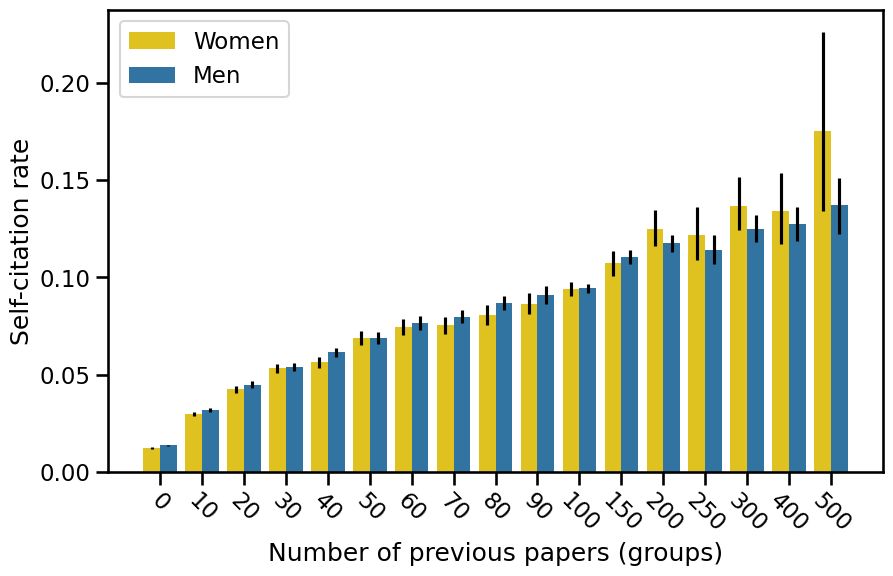

In [72]:
# Bin by number of previous papers and plot self-citation rates by gender
num_papers_groups = dat['num_papers_groups']
ngroups = len(num_papers_groups)
num_papers_sc_groups_male = dat['num_papers_sc_groups_male']
num_papers_sc_groups_female = dat['num_papers_sc_groups_female']

num_papers_sc_groups_male_lower = np.percentile(num_papers_sc_groups_male, q=2.5, axis=0)
num_papers_sc_groups_male_upper = np.percentile(num_papers_sc_groups_male, q=97.5, axis=0)

num_papers_sc_groups_female_lower = np.percentile(num_papers_sc_groups_female, q=2.5, axis=0)
num_papers_sc_groups_female_upper = np.percentile(num_papers_sc_groups_female, q=97.5, axis=0)


gender_binary = ['Women']*len(num_papers_groups)
gender_binary.extend(['Men']*len(num_papers_groups))

df_plot = pd.DataFrame({'gender_binary':gender_binary, 'num_papers_group':np.tile(num_papers_groups, 2), 'sc_rate':np.hstack( (np.mean(num_papers_sc_groups_female, axis=0), np.mean(num_papers_sc_groups_male, axis=0)) )})

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=df_plot, x='num_papers_group', y='sc_rate', ci=None, hue='gender_binary', ax=ax, palette=['#ffd700', (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)])


for i, p in enumerate(ax.patches[:(2*ngroups)]):
    x = p.get_x()  # get the bottom left x corner of the bar
    w = p.get_width()  # get width of bar
    h = p.get_height()  # get height of bar

    if i<ngroups:
        min_y = num_papers_sc_groups_female_lower[ i ]
        max_y = num_papers_sc_groups_female_upper[ i ]
    else:
        min_y = num_papers_sc_groups_male_lower[ i - ngroups]
        max_y = num_papers_sc_groups_male_upper[ i - ngroups]

    plt.vlines(x+w/2, min_y, max_y, color='k')  # draw a vertical line

plt.xticks(rotation=-45)
plt.legend(title='', loc='upper left')
plt.ylabel('Self-citation rate')
plt.xlabel('Number of previous papers (groups)')


Look at number of papers by ac age

Text(0, 0.5, 'Number of papers')

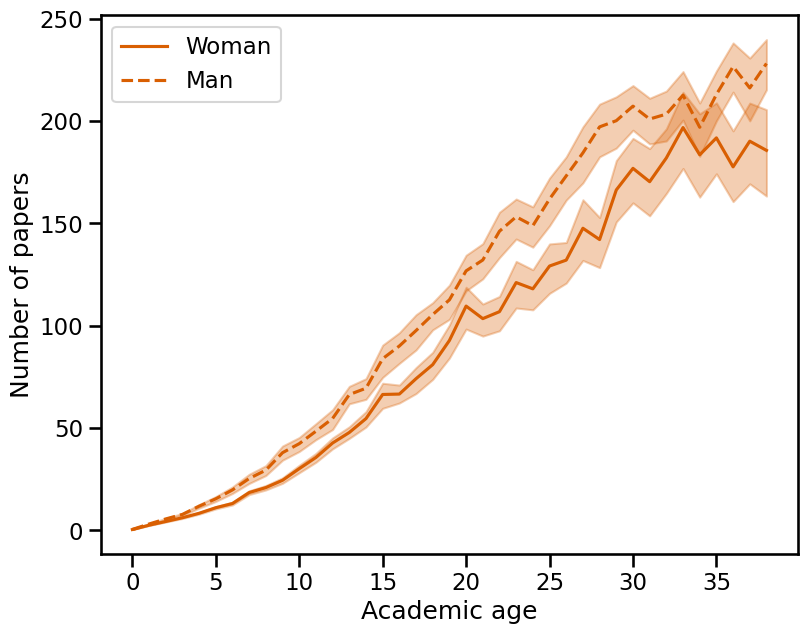

In [73]:
# Plot number of papers by academic age, grouped by gender
gender_palette = ['#0b03fc', '#fceb03']
gender_style = ['-', '--']

ac_ages = np.arange(np.shape(dat['num_papers_by_ac_age_male'])[1])

ac_age_gender_numpapers_female = dat['num_papers_by_ac_age_female'][:, :, 1]  # 0 is ac age

ac_age_gender_numpapers_male = dat['num_papers_by_ac_age_male'][:, :, 1]  # 0 is ac age


fig, ax = plt.subplots(figsize=(9, 7))

# for first author woman
ax.plot(ac_ages, np.mean(ac_age_gender_numpapers_female, axis=0), color=custom_palette[2], label='Woman', linestyle=gender_style[0])
ax.fill_between(ac_ages, np.percentile(ac_age_gender_numpapers_female, q=2.5, axis=0),
                np.percentile(ac_age_gender_numpapers_female, q=97.5, axis=0),
                color=custom_palette[2], alpha=.3)

# for first author man
ax.plot(ac_ages, np.mean(ac_age_gender_numpapers_male, axis=0), color=custom_palette[2], label='Man', linestyle=gender_style[1])
ax.fill_between(ac_ages, np.percentile(ac_age_gender_numpapers_male, q=2.5, axis=0),
                np.percentile(ac_age_gender_numpapers_male, q=97.5, axis=0),
                color=custom_palette[2], alpha=.3)

plt.legend()
plt.xlabel('Academic age')
plt.ylabel('Number of papers')
# ax.set_ylim([0, 1])


In [74]:
print(ac_age_gender_numpapers_male.mean(axis=0)[10])
print(np.std(ac_age_gender_numpapers_male,axis=0)[10])

42.31521052469806
1.764531912276183


(0.5, 2.5)

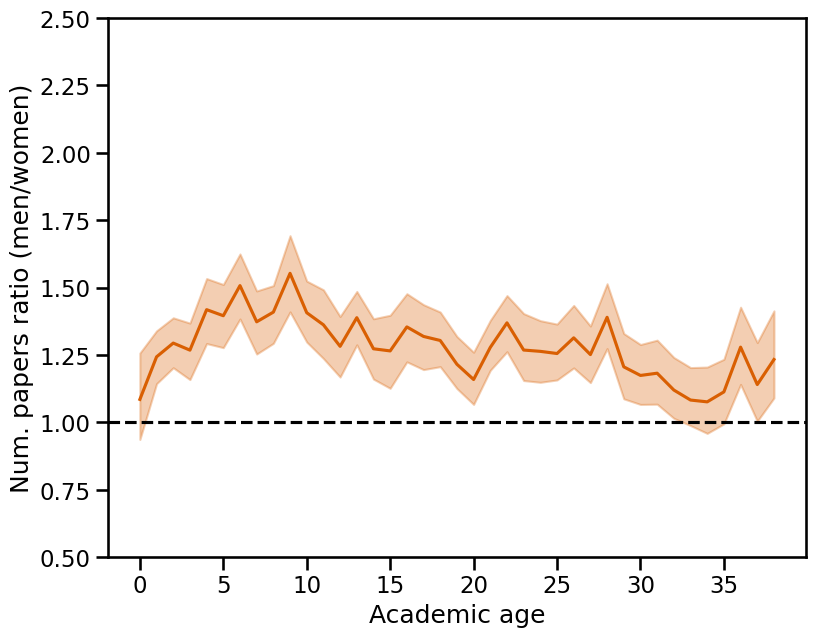

In [75]:
# Plot number of papers by academic age, ratio of men to women
gender_palette = ['#0b03fc', '#fceb03']
gender_style = ['-', '--']

ac_ages = np.arange(np.shape(dat['num_papers_by_ac_age_male'])[1])

ac_age_gender_numpapers_female = dat['num_papers_by_ac_age_female'][:, :, 1]  # 0 is ac age

ac_age_gender_numpapers_male = dat['num_papers_by_ac_age_male'][:, :, 1]  # 0 is ac age
paper_ratio_ac_age = ac_age_gender_numpapers_male / ac_age_gender_numpapers_female


fig, ax = plt.subplots(figsize=(9, 7))

# for ratio of papers by academic age
ax.plot(ac_ages, np.mean(paper_ratio_ac_age, axis=0), color=custom_palette[2])
ax.fill_between(ac_ages, np.percentile(paper_ratio_ac_age, q=2.5, axis=0),
                np.percentile(paper_ratio_ac_age, q=97.5, axis=0),
                color=custom_palette[2], alpha=.3)


ax.axhline(y=1, color='black', linestyle='--')
plt.xlabel('Academic age')
plt.ylabel('Num. papers ratio (men/women)')
ax.set_ylim([0.5, 2.5])


# num auth by field

<Axes: xlabel='num_auth_citing', ylabel='sc_rate'>

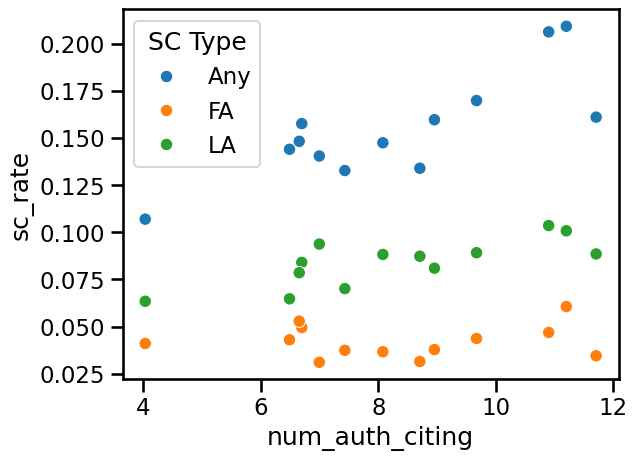

In [77]:
# plot self-citation rate for each topic versus average number of authors
df_topics = df[df['Year'].isin([2016, 2017, 2018, 2019, 2020])].reset_index(drop=True)
df_topics = df_topics[df_topics['topic']!='Error']
df_topics_summary = df_topics.groupby(['topic', 'SC Type'], as_index=False).agg({'num_auth_citing':'mean', 'numpapers':'sum', 'sc_count':'sum', 'numref':'sum'})
df_topics_summary['topic'] = [int(t) for t in df_topics_summary.topic]
df_topics_summary['sc_rate'] = df_topics_summary['sc_count'] / df_topics_summary['numref']
df_topics_summary = df_topics_summary.sort_values('topic')
topic_names = np.array(['Clinical research', 'Aging & development', 'Dementia', 'Functional imaging',
               'Pain', 'Animal models', 'Stroke', 'Clinical trials', 'Schizophrenia', 'Cellular',
               'Mechanistic', 'Depression & anxiety', 'Social neuroscience'])
topic_name_dict = dict([(key,value) for key,value in zip(np.arange(len(topic_names)), topic_names)])
df_topics_summary['topic'] = df_topics_summary['topic'].replace(topic_name_dict)
df_topics_summary[df_topics_summary['SC Type']=='FA']
sns.scatterplot(data=df_topics_summary, x='num_auth_citing', y='sc_rate', hue='SC Type')

In [78]:
# correlation between number of authors and self-cictation rate

for auth_type in ['FA', 'LA', 'Any']:
    r, p = spearmanr(np.array(df_topics_summary[df_topics_summary['SC Type']==auth_type].num_auth_citing), np.array(df_topics_summary[df_topics_summary['SC Type']==auth_type].sc_rate))
    print(auth_type + " Spearman's r={:.6f}, p={:.6f}".format( r, p ) )

FA Spearman's r=-0.032967, p=0.914856
LA Spearman's r=0.758242, p=0.002666
Any Spearman's r=0.736264, p=0.004108


# Coefficients over 100 seeds

In [81]:
df_tmp = pd.read_csv('https://raw.githubusercontent.com/mattrosenblatt7/self_citation/main/results/model_100_seed_results.csv')
df_tmp.head()


,Unnamed: 0,seed,auth_type,model_type,(Intercept),fieldNeuro,fieldNeurology,gendermale,affil_lmicTrue,document_typeReview
0,1,1,fa,rate,-3.635606,0.111624,-0.130597,-0.025827,-0.127202,-0.064148
1,2,1,fa,count,0.045902,0.147111,-0.093011,-0.009489,-0.116034,-0.041821
2,3,1,fa,papers,2.296044,-0.194863,0.025800,0.245947,0.071253,0.152005
3,4,1,la,rate,-2.927762,0.185664,-0.062122,-0.046580,-0.237492,-0.142675
4,5,1,la,count,0.747708,0.184117,-0.025071,-0.032960,-0.241250,-0.139235


In [82]:
df = pd.melt(df_tmp, id_vars=['seed', 'auth_type', 'model_type'],
        value_vars=['fieldNeuro', 'fieldNeurology', 'gendermale',
                    'affil_lmicTrue', 'document_typeReview'],
       var_name='coef_name', value_name='coef_val')

<ipython-input-83-496827aa8c83>:2: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  g = sns.catplot(data=df, x='coef_name', y='coef_val',
<ipython-input-83-496827aa8c83>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')


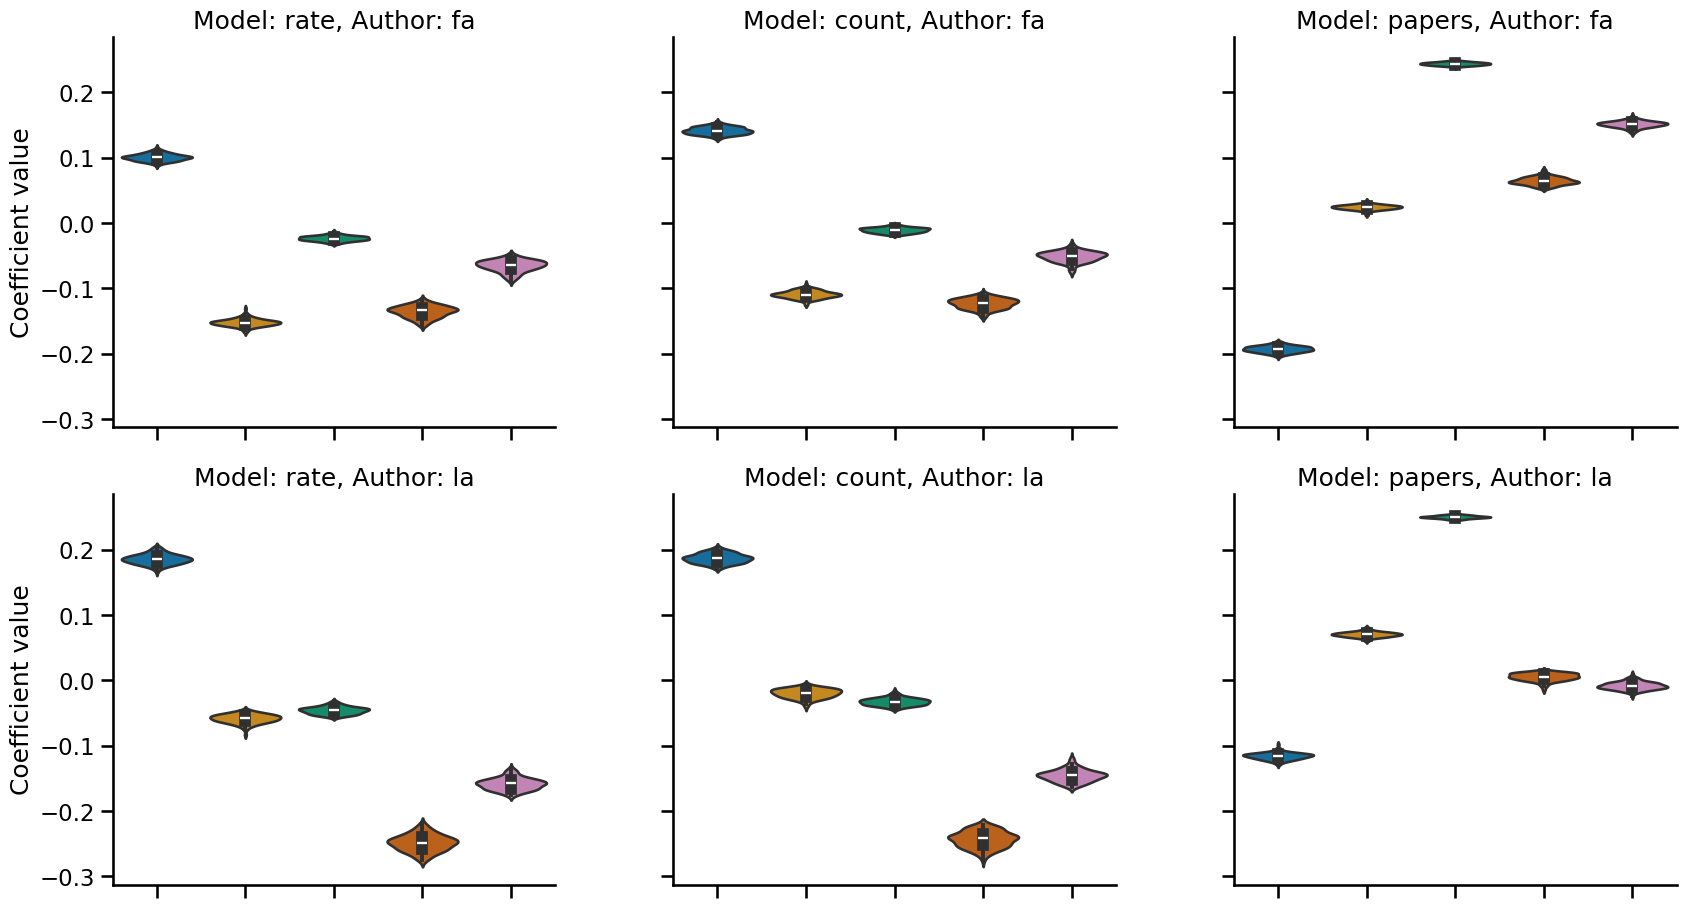

In [83]:
sns.set_context('talk')
g = sns.catplot(data=df, x='coef_name', y='coef_val',
            col='model_type', row='auth_type', aspect=1.2, kind='violin',
               palette=sns.color_palette('colorblind') )
g.set_ylabels('Coefficient value')
g.set_xlabels('')
g.set_titles("Model: {col_name}, Author: {row_name}")

# rotate tick labels
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

plt.show()